In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import LassoLars

from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, f_regression, RFE

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import LassoLars


# import my functions
import prepare

# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

In [2]:
red = pd.read_csv('winequality-red.csv')
white = pd.read_csv('winequality-white.csv')

In [3]:
red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
red.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [5]:
white.quality.value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [6]:
wine = pd.concat(map(pd.read_csv, ['winequality-red.csv', 'winequality-white.csv']), ignore_index=True)
wine.shape

(6497, 12)

In [7]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
wine.shape

(6497, 12)

In [9]:
wine.rename(columns = {'fixed acidity' : 'fixed_acidity', 'volatile acidity' : 'volatile_acidity', 
                       'citric acid' : 'citric_acid', 'residual sugar': 'rs', 'free sulfur dioxide': 'free_s02',
                       'total sulfur dioxide' : 'total_s02'}, inplace = True)

In [10]:
wine.head(1)

,fixed_acidity,volatile_acidity,citric_acid,rs,chlorides,free_s02,total_s02,density,pH,sulphates,alcohol,quality
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [11]:
wine['quality'].head()

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64

<AxesSubplot:ylabel='total_s02'>

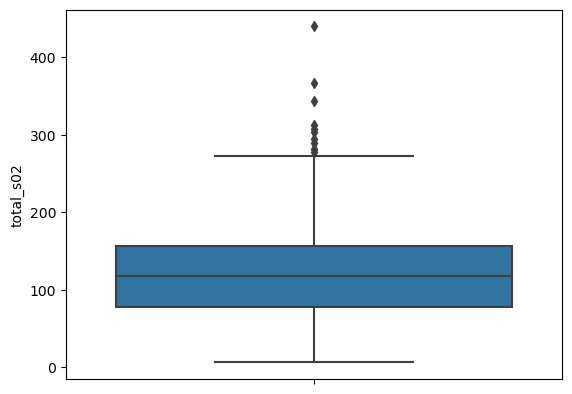

In [12]:
sns.boxplot(data=wine, y = 'total_s02')


In [13]:
def remove_outliers(df, k=2):
    '''
    This function is to remove the top 25% and bottom 25% of the data for each column.
    This removes the top and bottom 50% for every column to ensure all outliers are gone.
    '''
    a=[]
    b=[]
    fences=[a, b]
    features= []
    col_list = []
    i=0
    for col in df:
            new_df=np.where(df[col].nunique()>8, True, False)
            if new_df==True:
                if df[col].dtype == 'float' or df[col].dtype == 'int':
                    '''
                    for each feature find the first and third quartile
                    '''
                    q1, q3 = df[col].quantile([.25, .75])
                    '''
                    calculate inter quartile range
                    '''
                    iqr = q3 - q1
                    '''
                    calculate the upper and lower fence
                    '''
                    upper_fence = q3 + (k * iqr)
                    lower_fence = q1 - (k * iqr)
                    '''
                    appending the upper and lower fences to lists
                    '''
                    a.append(upper_fence)
                    b.append(lower_fence)
                    '''
                    appending the feature names to a list
                    '''
                    features.append(col)
                    '''
                    assigning the fences and feature names to a dataframe
                    '''
                    var_fences= pd.DataFrame(fences, columns=features, index=['upper_fence', 'lower_fence'])
                    col_list.append(col)
                else:
                    print(col)
                    print('column is not a float or int')
            else:
                print(f'{col} column ignored')
    '''
    for loop used to remove the data deemed unecessary
    '''
    for col in col_list:
        df = df[(df[col]<= a[i]) & (df[col]>= b[i])]
        i+=1
    return df, var_fences
     

In [14]:
wine, var_fences = remove_outliers(wine)

quality column ignored


In [15]:
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,rs,chlorides,free_s02,total_s02,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7


In [16]:
wine.shape

(5757, 12)

In [17]:
wine.quality.value_counts()

6    2533
5    1851
7    1004
8     179
4     172
3      13
9       5
Name: quality, dtype: int64

In [18]:
wine.describe()
    

,fixed_acidity,volatile_acidity,citric_acid,rs,chlorides,free_s02,total_s02,density,pH,sulphates,alcohol,quality
count,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000
mean,7.034176,0.319750,0.307355,5.591906,0.050010,31.125413,119.781136,0.994420,3.218933,0.514530,10.519964,5.851138
std,0.974296,0.137262,0.122002,4.715453,0.018637,16.437084,53.638754,0.002858,0.155408,0.123028,1.200953,0.863658
min,3.900000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.220000,0.250000,1.800000,0.037000,18.000000,87.000000,0.992050,3.110000,0.420000,9.500000,5.000000
50%,6.900000,0.280000,0.310000,3.400000,0.046000,29.000000,121.000000,0.994560,3.210000,0.500000,10.400000,6.000000
75%,7.500000,0.380000,0.380000,8.400000,0.057000,42.000000,157.000000,0.996660,3.320000,0.590000,11.400000,6.000000
max,10.300000,0.740000,0.670000,20.700000,0.119000,89.000000,303.000000,1.002600,3.720000,0.940000,14.200000,9.000000


In [19]:
#Removing the very few super high quality wines and very few super low quality wines
wine = wine[wine.quality != 9]
wine = wine[wine.quality != 3]

In [20]:
#After removing the high and low qualities we only removed 18 lines(13 low, 5 high) from the dataset
wine.shape

(5739, 12)

# Our wine quality categories now range from 4 to 8

In [21]:
wine.quality.value_counts()

6    2533
5    1851
7    1004
8     179
4     172
Name: quality, dtype: int64

In [24]:
train, val, test = prepare.train_val_test(wine)
train.shape, val.shape, test.shape

((4017, 12), (1033, 12), (689, 12))

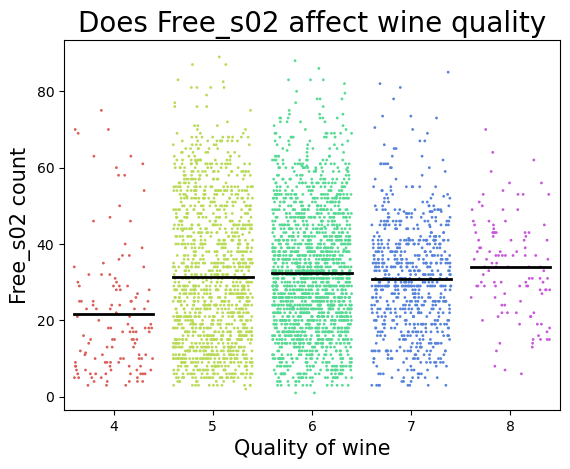

In [25]:
# Creating a visual displaying amount distro comapred to mean
p = sns.stripplot(y =train.free_s02, x = train.quality, data = train, size = 2, jitter = .4, palette = 'hls')
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="quality",
            y="free_s02",
            data=train,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.ylabel('Free_s02 count', fontdict = { 'fontsize': 15})
plt.xlabel('Quality of wine', fontdict = { 'fontsize': 15})
plt.title('Does Free_s02 affect wine quality', fontdict = { 'fontsize': 20})
plt.show()